In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)
import matplotlib.image as mpimg

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers, models, losses


print(tf.__version__)
print(sklearn.__version__)
print(np.__version__)

2.6.0


## data

In [2]:
# !mkdir -p ~/aiffel/medical
# !ln -s ~/data/* ~/aiffel/medical

In [2]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [4]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [5]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


## data pipeline and preprocessing

In [6]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

In [7]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

In [8]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

In [9]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

In [ ]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [11]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [12]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

## prev. results

In [35]:
history = model.fit(
    train_dataset,
    epochs=max_epochs,    # 10
    steps_per_epoch=num_train_examples//batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples//batch_size,
    callbacks=[cp_callback, lr_callback]
)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 37s 810ms/step - loss: 1.0371 - dice_loss: 0.7285 - val_loss: 1089.1038 - val_dice_loss: 0.9035
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 26s 811ms/step - loss: 0.9232 - dice_loss: 0.7022 - val_loss: 419.7092 - val_dice_loss: 0.9987
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 26s 825ms/step - loss: 0.9147 - dice_loss: 0.7089 - val_loss: 1031.7667 - val_dice_loss: 1.0000
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 27s 848ms/step - loss: 0.9033 - dice_loss: 0.6993 - val_loss: 31.5

In [40]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9498831735779099


## improving U-Net

In [ ]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
#         self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.depthwise = layers.SeparableConv2D(num_filters, kernel_size, padding='same')  # v.3
        self.bn = layers.BatchNormalization(momentum=0.9)

    def call(self, inputs, training=True):
#         x = self.conv(inputs)
        x = self.depthwise(inputs)  # v.3
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)
        return x

class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)
        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)
        return decoder

class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)
        return encoder_pool, encoder

class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)
        self.dropout = layers.Dropout(0.5)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = layers.Concatenate(axis=-1)([decoder, concat_tensor])
        decoder = self.dropout(decoder, training=training)
        decoder = self.conv_block_r(decoder, training=training)
        return decoder

In [ ]:
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(AttentionBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, 1, activation='relu')
        self.conv2 = layers.Conv2D(filters, 1, activation='sigmoid')
#         self.upsample = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same')

    def call(self, input_tensor, skip_tensor):
        # Upsample the skip_tensor to match the input_tensor dimensions
#         skip_tensor = self.upsample(skip_tensor)

        # v.4
        # Resize skip_tensor to match the dimensions of input_tensor
        skip_tensor = tf.image.resize(skip_tensor, tf.shape(input_tensor)[1:3])

        attention = self.conv1(skip_tensor)
        attention = self.conv2(attention)
        return input_tensor * attention

In [125]:
class EnhancedAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, filters, num_heads=4):
        """
        Enhanced attention block with multi-head attention and global context pooling.
        :param filters: Number of filters for the convolution layers.
        :param num_heads: Number of attention heads for multi-head attention.
        """
        super(EnhancedAttentionBlock, self).__init__()
        self.filters = filters
        self.num_heads = num_heads

        # Global context pooling
        self.global_pool = layers.GlobalAveragePooling2D()
        self.global_dense = layers.Dense(filters, activation='relu')

        # Multi-head self-attention components
        self.query_conv = layers.Conv2D(filters, kernel_size=1)
        self.key_conv = layers.Conv2D(filters, kernel_size=1)
        self.value_conv = layers.Conv2D(filters, kernel_size=1)
        self.softmax = layers.Softmax(axis=-1)

        # Combining features
        self.output_conv = layers.Conv2D(filters, kernel_size=1, activation='sigmoid')

    def call(self, input_tensor, skip_tensor):
        # Resize skip_tensor to match input_tensor dimensions
        skip_tensor = tf.image.resize(skip_tensor, tf.shape(input_tensor)[1:3])

        # Global context pooling from skip_tensor
        global_context = self.global_pool(skip_tensor)
        global_context = tf.expand_dims(tf.expand_dims(global_context, axis=1), axis=1)
        global_context = self.global_dense(global_context)

        # Multi-head attention
        query = self.query_conv(input_tensor)  # Query from input tensor
        key = self.key_conv(skip_tensor)      # Key from skip tensor
        value = self.value_conv(skip_tensor)  # Value from skip tensor

        # Compute attention scores
        attention_scores = tf.einsum('bhwc,bhwc->bhwc', query, key)
        attention_scores = self.softmax(attention_scores)

        # Weighted combination of values
        attention_output = tf.einsum('bhwc,bhwc->bhwc', attention_scores, value)

        # Combine global context and attention output
        combined_features = attention_output + global_context
        combined_features = self.output_conv(combined_features)

        # Apply attention weights to the input tensor
        return input_tensor * combined_features

In [ ]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self, input_shape=(256, 256, 3), num_classes=1):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

        for layer in self.vgg16.layers:
            layer.trainable = False  # Freeze vgg16 layers

        # v.1
        for layer in self.vgg16.layers[-4:]:  # Unfreeze last 4 layers
            layer.trainable = True


        self.encoder_layers = [
            self.vgg16.get_layer(name).output
            for name in ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
        ]
        self.vgg16_act = tf.keras.Model(inputs=self.vgg16.input, outputs=self.encoder_layers)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.attention4 = EnhancedAttentionBlock(512)
        self.attention3 = EnhancedAttentionBlock(256)
        self.attention2 = EnhancedAttentionBlock(128)
        self.attention1 = EnhancedAttentionBlock(64)

        activation = 'sigmoid' if num_classes == 1 else 'softmax'
        self.output_conv = layers.Conv2D(num_classes, 1, activation=activation)

    def call(self, inputs, training=True):
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)
        center = self.center(center, training=training)

        decoder4 = self.decoder_block4(center, self.attention4(encoder4, center), training=training)
        decoder3 = self.decoder_block3(decoder4, self.attention3(encoder3, decoder4), training=training)
        decoder2 = self.decoder_block2(decoder3, self.attention2(encoder2, decoder3), training=training)
        decoder1 = self.decoder_block1(decoder2, self.attention1(encoder1, decoder2), training=training)

        outputs = self.output_conv(decoder1)
        return outputs

In [ ]:
# v.0
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    bce = losses.binary_crossentropy(y_true, y_pred)
    bce = tf.reduce_mean(bce)
    dice = dice_loss(y_true, y_pred)
    loss =  bce + dice
    return loss

def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    return 1 - (2. * intersection + 1e-7) / (union + 1e-7)

In [94]:
# v.3
def smoothed_dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    return 1 - (2. * intersection + smooth) / (union + smooth)

In [130]:
checkpoint_name = 'train_ckpt/unet_vgg16_attention'
checkpoint_dir =os.path.join(DATASET_PATH, checkpoint_name)


model = Vgg16UNet(input_shape=(256, 256, 3), num_classes=1)

initial_learning_rate = 1e-4  # v.4: 1e-3
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,  # v.4: 100000
    decay_rate=0.9,  # v.4: 0.96
    staircase=True
#     staircase=False  # v.4
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=bce_dice_loss,
#     metrics=[dice_loss]
    metrics=[smoothed_dice_loss]    # v.3
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose=0
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)


In [66]:
# v.0
history = model.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=num_train_examples//batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples//batch_size,
    callbacks=[cp_callback, lr_scheduler]
)

Epoch 1/10
30/30 [==============================] - 24s 745ms/step - loss: 1.2244 - iou_metric: 0.0891 - val_loss: 6.8034 - val_iou_metric: 0.0566
Epoch 2/10
30/30 [==============================] - 24s 762ms/step - loss: 0.9788 - iou_metric: 0.1610 - val_loss: 1.2756 - val_iou_metric: 0.0709
Epoch 3/10
30/30 [==============================] - 25s 775ms/step - loss: 0.8550 - iou_metric: 0.2089 - val_loss: 1.2401 - val_iou_metric: 0.0721
Epoch 4/10
30/30 [==============================] - 25s 786ms/step - loss: 0.7644 - iou_metric: 0.2514 - val_loss: 1.1321 - val_iou_metric: 0.1183
Epoch 5/10
30/30 [==============================] - 25s 780ms/step - loss: 0.6995 - iou_metric: 0.2907 - val_loss: 1.0004 - val_iou_metric: 0.1332
Epoch 6/10
30/30 [==============================] - 25s 778ms/step - loss: 0.6507 - iou_metric: 0.3202 - val_loss: 0.8382 - val_iou_metric: 0.1998
Epoch 7/10
30/30 [==============================] - 25s 786ms/step - loss: 0.5809 - iou_metric: 0.3674 - val_loss: 0.7

In [74]:
# v.1
history = model.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=num_train_examples//batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples//batch_size,
    callbacks=[cp_callback, lr_scheduler]
)

Epoch 1/10
30/30 [==============================] - 26s 746ms/step - loss: 1.6269 - dice_loss: 0.8292 - val_loss: 5.7436 - val_dice_loss: 0.9043
Epoch 2/10
30/30 [==============================] - 24s 743ms/step - loss: 1.2091 - dice_loss: 0.7644 - val_loss: 9.9219 - val_dice_loss: 0.9016
Epoch 3/10
30/30 [==============================] - 24s 759ms/step - loss: 0.9311 - dice_loss: 0.6102 - val_loss: 1.5051 - val_dice_loss: 0.7713
Epoch 4/10
30/30 [==============================] - 24s 772ms/step - loss: 0.7106 - dice_loss: 0.4552 - val_loss: 1.3422 - val_dice_loss: 0.7369
Epoch 5/10
30/30 [==============================] - 25s 784ms/step - loss: 0.5555 - dice_loss: 0.3637 - val_loss: 1.2016 - val_dice_loss: 0.7209
Epoch 6/10
30/30 [==============================] - 25s 782ms/step - loss: 0.4979 - dice_loss: 0.3266 - val_loss: 0.9570 - val_dice_loss: 0.6123
Epoch 7/10
30/30 [==============================] - 25s 778ms/step - loss: 0.4133 - dice_loss: 0.2653 - val_loss: 0.8453 - val_dic

In [86]:
# v.2 - unfreeze last 4 layers, lr_scheduler
history = model.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=num_train_examples//batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples//batch_size,
    callbacks=[cp_callback, lr_scheduler]
)

Epoch 1/10
30/30 [==============================] - 28s 799ms/step - loss: 1.3069 - dice_loss: 0.8945 - val_loss: 1.1833 - val_dice_loss: 0.8653
Epoch 2/10
30/30 [==============================] - 25s 797ms/step - loss: 1.0856 - dice_loss: 0.7762 - val_loss: 1.0157 - val_dice_loss: 0.7606
Epoch 3/10
30/30 [==============================] - 25s 796ms/step - loss: 0.8778 - dice_loss: 0.6809 - val_loss: 0.8632 - val_dice_loss: 0.6586
Epoch 4/10
30/30 [==============================] - 25s 794ms/step - loss: 0.7269 - dice_loss: 0.5900 - val_loss: 0.5776 - val_dice_loss: 0.4908
Epoch 5/10
30/30 [==============================] - 25s 799ms/step - loss: 0.6309 - dice_loss: 0.5187 - val_loss: 0.5425 - val_dice_loss: 0.4362
Epoch 6/10
30/30 [==============================] - 26s 792ms/step - loss: 0.5452 - dice_loss: 0.4626 - val_loss: 0.4343 - val_dice_loss: 0.3595
Epoch 7/10
30/30 [==============================] - 25s 796ms/step - loss: 0.5068 - dice_loss: 0.4268 - val_loss: 0.4181 - val_dic

In [101]:
# v.3 - depthwise, smoothed_dice_loss
history = model.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=num_train_examples//batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples//batch_size,
    callbacks=[cp_callback, lr_scheduler]
)

Epoch 1/10
30/30 [==============================] - 29s 804ms/step - loss: 1.7093 - smoothed_dice_loss: 0.9079 - val_loss: 1.6071 - val_smoothed_dice_loss: 0.9131
Epoch 2/10
30/30 [==============================] - 25s 804ms/step - loss: 1.5587 - smoothed_dice_loss: 0.9015 - val_loss: 1.5001 - val_smoothed_dice_loss: 0.9045
Epoch 3/10
30/30 [==============================] - 26s 822ms/step - loss: 1.3702 - smoothed_dice_loss: 0.8812 - val_loss: 1.3063 - val_smoothed_dice_loss: 0.8579
Epoch 4/10
30/30 [==============================] - 26s 831ms/step - loss: 1.1477 - smoothed_dice_loss: 0.8001 - val_loss: 1.0445 - val_smoothed_dice_loss: 0.7751
Epoch 5/10
30/30 [==============================] - 27s 844ms/step - loss: 0.9649 - smoothed_dice_loss: 0.7251 - val_loss: 0.8673 - val_smoothed_dice_loss: 0.6872
Epoch 6/10
30/30 [==============================] - 26s 834ms/step - loss: 0.8447 - smoothed_dice_loss: 0.6605 - val_loss: 0.8118 - val_smoothed_dice_loss: 0.6401
Epoch 7/10
30/30 [====

In [118]:
# v.4 - early_stopping, attention - resize
history = model.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=num_train_examples//batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples//batch_size,
    callbacks=[
        cp_callback,
        lr_scheduler,
        early_stopping,
#         tensorboard_callback
    ]
)

# it is trained two epochs before 10 epochs

Epoch 1/10
30/30 [==============================] - 24s 740ms/step - loss: 0.8469 - smoothed_dice_loss: 0.6710 - val_loss: 1.2666 - val_smoothed_dice_loss: 0.5900
Epoch 2/10
30/30 [==============================] - 24s 751ms/step - loss: 0.6221 - smoothed_dice_loss: 0.5112 - val_loss: 1.2965 - val_smoothed_dice_loss: 0.5781
Epoch 3/10
30/30 [==============================] - 24s 767ms/step - loss: 0.4811 - smoothed_dice_loss: 0.3961 - val_loss: 0.7463 - val_smoothed_dice_loss: 0.4596
Epoch 4/10
30/30 [==============================] - 25s 783ms/step - loss: 0.3846 - smoothed_dice_loss: 0.3130 - val_loss: 0.7814 - val_smoothed_dice_loss: 0.4281
Epoch 5/10
30/30 [==============================] - 24s 761ms/step - loss: 0.3315 - smoothed_dice_loss: 0.2676 - val_loss: 0.3727 - val_smoothed_dice_loss: 0.2881
Epoch 6/10
30/30 [==============================] - 24s 754ms/step - loss: 0.2743 - smoothed_dice_loss: 0.2217 - val_loss: 0.8402 - val_smoothed_dice_loss: 0.4147
Epoch 7/10
30/30 [====

In [132]:
# v.5 - enhance attention block
history = model.fit(
    train_dataset,
    epochs=10,
    steps_per_epoch=num_train_examples//batch_size,
    validation_data=test_dataset,
    validation_steps=num_test_examples//batch_size,
    callbacks=[
        cp_callback,
        lr_scheduler,
        early_stopping,
    ]
)

Epoch 1/10
30/30 [==============================] - 98s 3s/step - loss: 1.5690 - smoothed_dice_loss: 0.8992 - val_loss: 1.6782 - val_smoothed_dice_loss: 0.9087
Epoch 3/10
30/30 [==============================] - 98s 3s/step - loss: 1.3291 - smoothed_dice_loss: 0.8536 - val_loss: 1.3111 - val_smoothed_dice_loss: 0.8401
Epoch 4/10
30/30 [==============================] - 98s 3s/step - loss: 1.1212 - smoothed_dice_loss: 0.7881 - val_loss: 0.9987 - val_smoothed_dice_loss: 0.7266
Epoch 5/10
30/30 [==============================] - 98s 3s/step - loss: 0.9637 - smoothed_dice_loss: 0.7237 - val_loss: 0.8291 - val_smoothed_dice_loss: 0.6298
Epoch 6/10
30/30 [==============================] - 98s 3s/step - loss: 0.8403 - smoothed_dice_loss: 0.6603 - val_loss: 0.7020 - val_smoothed_dice_loss: 0.5865
Epoch 7/10
30/30 [==============================] - 98s 3s/step - loss: 0.7699 - smoothed_dice_loss: 0.6205 - val_loss: 0.6279 - val_smoothed_dice_loss: 0.5379
Epoch 8/10
30/30 [======================

### ++ evaluation

In [102]:
def plot_results(history, loss_name='loss', dice_loss_name='dice_loss'):
    dice_loss = history.history[dice_loss_name]
    loss = history.history[loss_name]
    val_dice_loss = history.history[f'val_{dice_loss_name}']
    val_loss = history.history[f'val_{loss_name}']

    epochs_range = range(max_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Loss')
    plt.plot(epochs_range, dice_loss, label='Dice Loss')
    plt.legend(loc='upper right')
    plt.title('Train Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
    plt.legend(loc='upper right')
    plt.title('Valid Loss')
    plt.show()

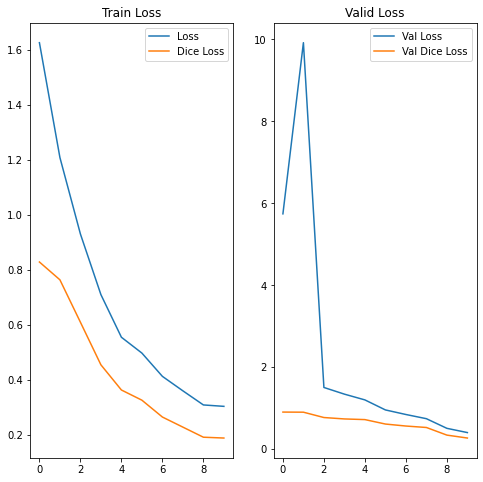

In [76]:
# v.1
plot_results(history)

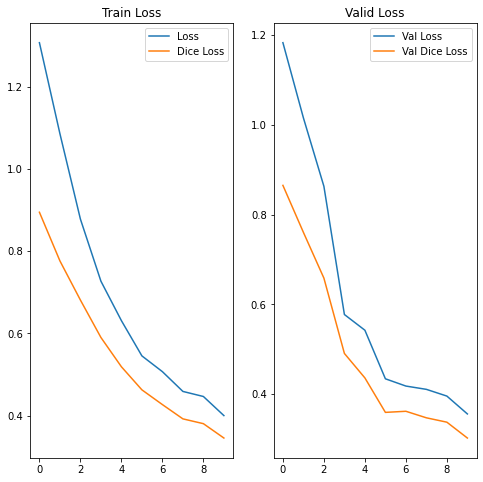

In [88]:
# v.2
plot_results(history)

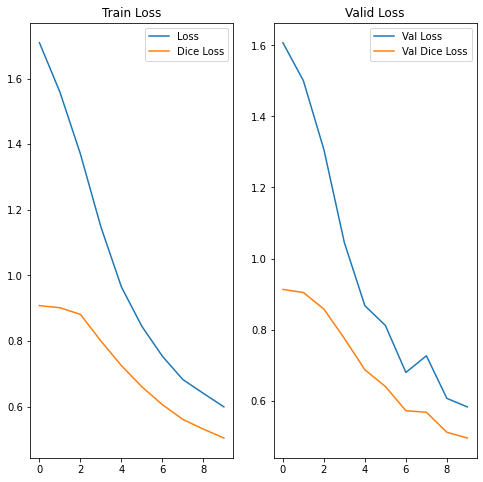

In [103]:
# v.3
plot_results(history, dice_loss_name='smoothed_dice_loss')

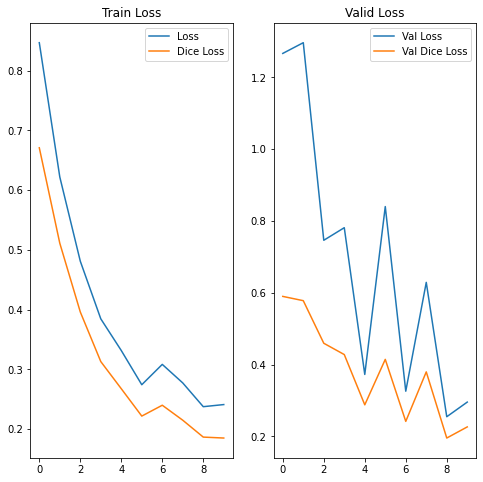

In [119]:
# v.4
plot_results(history, dice_loss_name='smoothed_dice_loss')

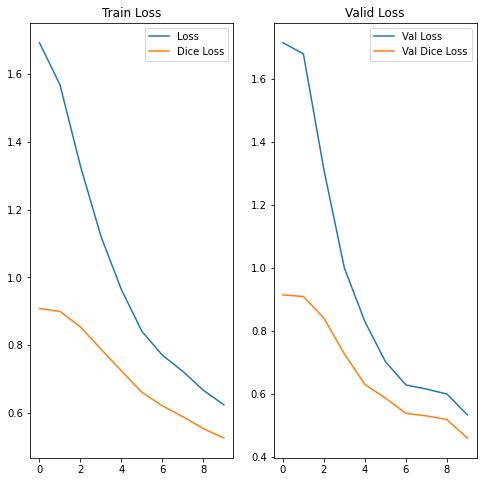

In [133]:
# v.5
plot_results(history, dice_loss_name='smoothed_dice_loss')

In [134]:
checkpoint_name = 'train_ckpt/unet_vgg16_attention'
checkpoint_dir = os.path.join(DATASET_PATH, checkpoint_name)
model.load_weights(checkpoint_dir)

#### -- mean IoU

In [ ]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)


In [90]:
def get_mean_iou(test_dataset, model):
    mean = []

    for images, labels in test_dataset:
        predictions = model(images, training=False)
        m = mean_iou(labels, predictions)
        mean.append(m)

    mean = np.array(mean)
    mean = np.mean(mean)
    return mean

In [79]:
# v.1
print("mean_iou: {}".format(mean))

mean_iou: 0.8123581686051939


In [91]:
# v.2
mean = get_mean_iou(test_dataset, model)
print("mean_iou: {}".format(mean))

mean_iou: 0.876398149182533


In [105]:
# v.3
mean = get_mean_iou(test_dataset, model)
print("mean_iou: {}".format(mean))

mean_iou: 0.8365073907878364


In [121]:
# v.4
mean = get_mean_iou(test_dataset, model)
print("mean_iou: {}".format(mean))

mean_iou: 0.8690246456103503


In [135]:
# v.5
mean = get_mean_iou(test_dataset, model)
print("mean_iou: {}".format(mean))

mean_iou: 0.8508797456171711


#### -- print_images()

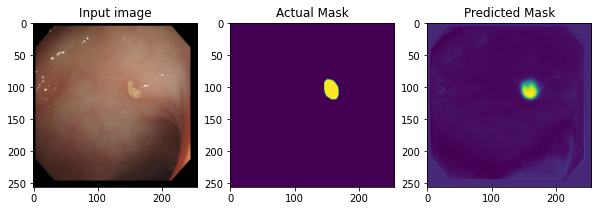

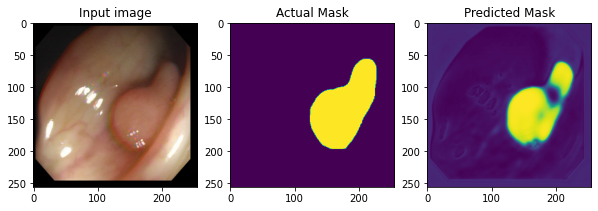

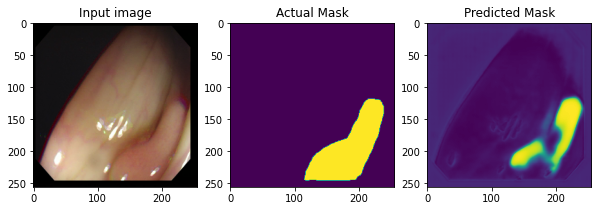

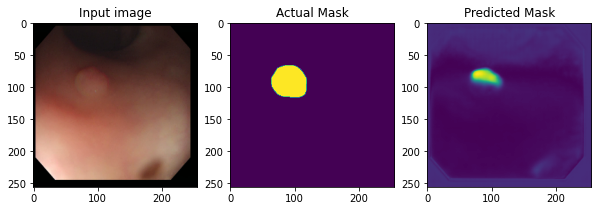

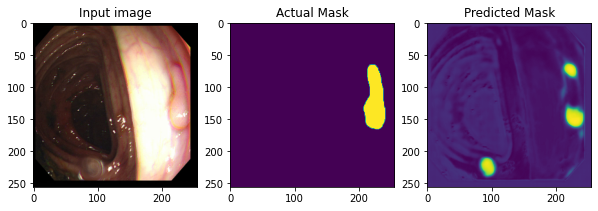

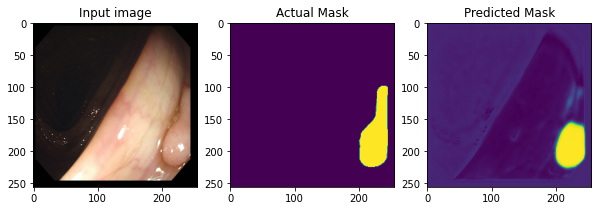

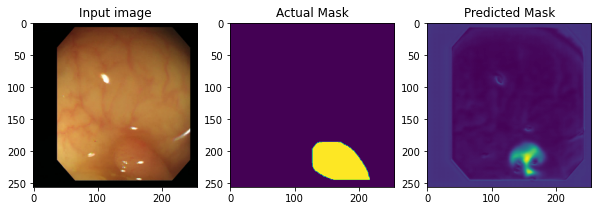

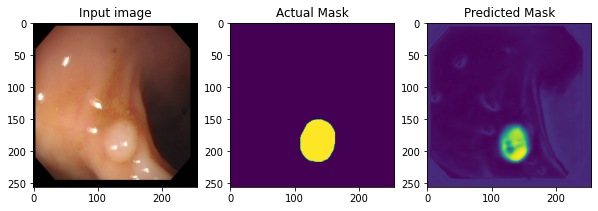

In [80]:
# v.1
print_images()

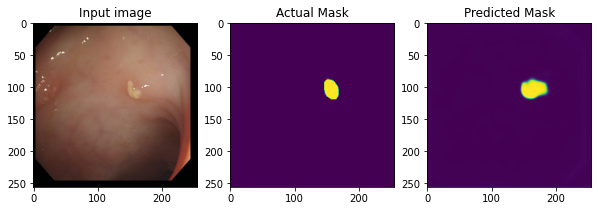

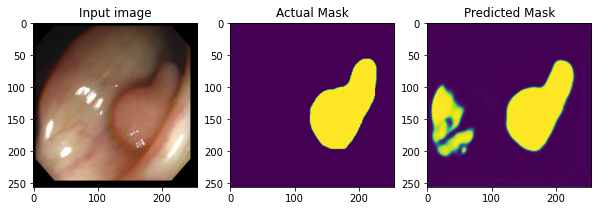

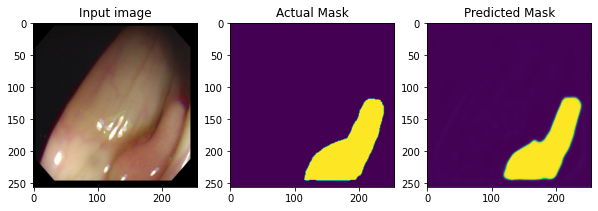

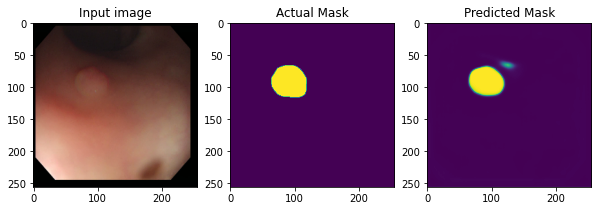

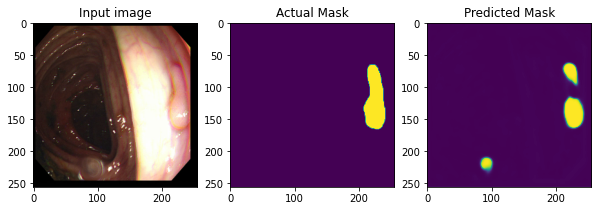

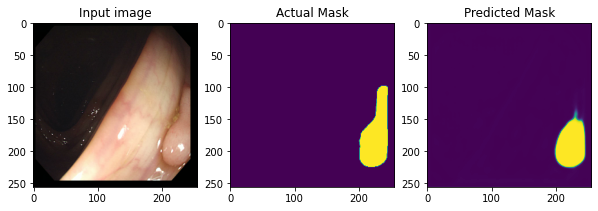

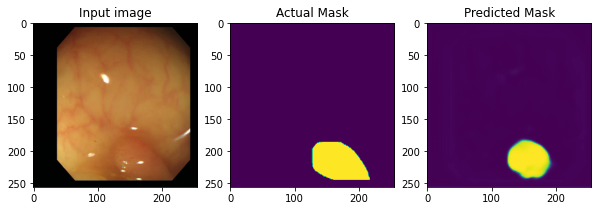

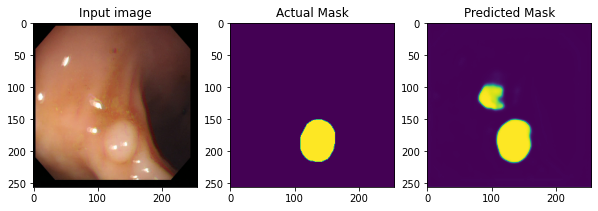

In [92]:
# v.2
print_images()

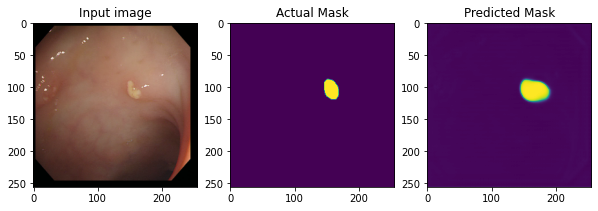

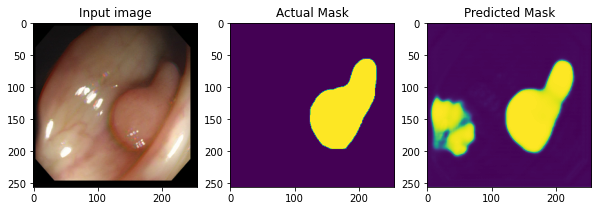

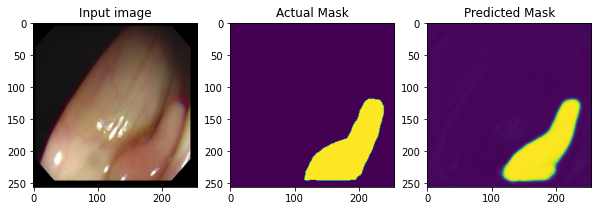

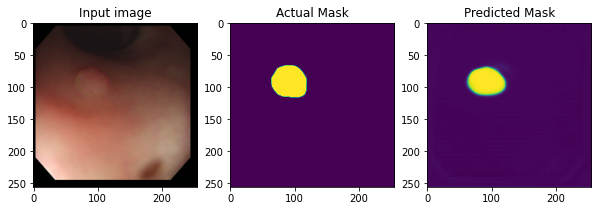

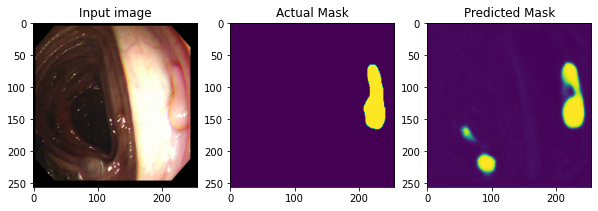

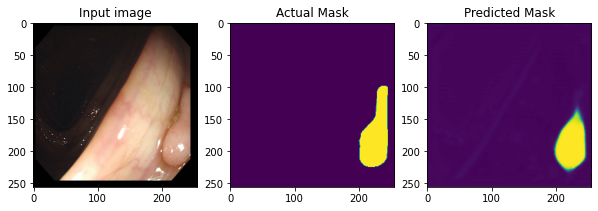

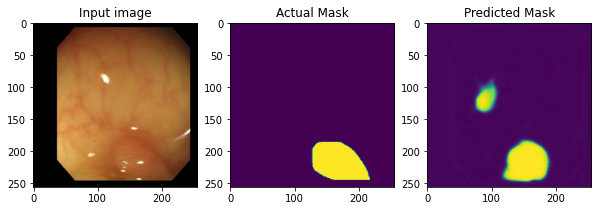

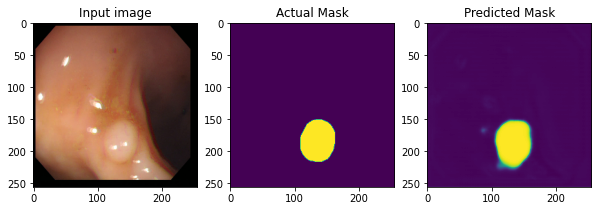

In [106]:
# v.3
print_images()

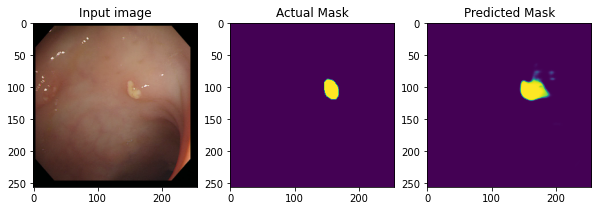

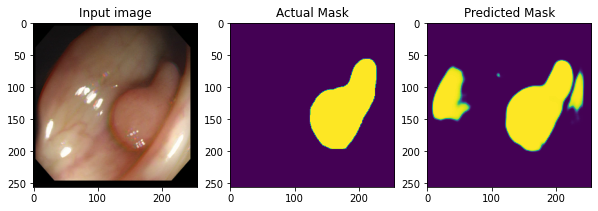

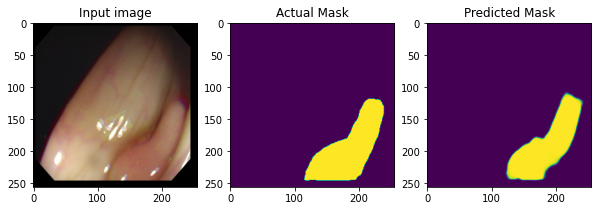

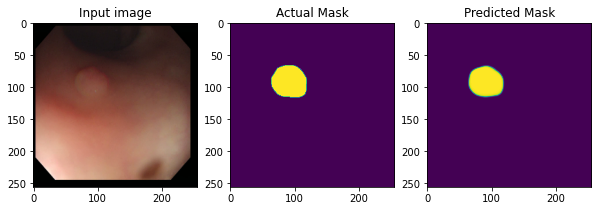

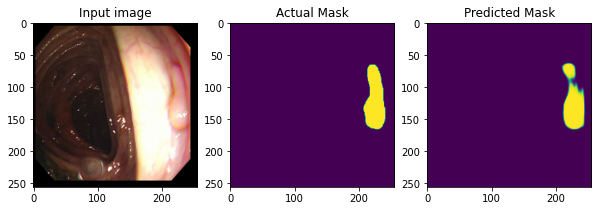

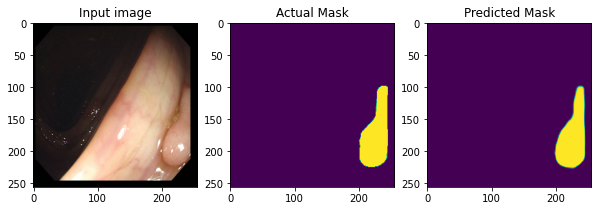

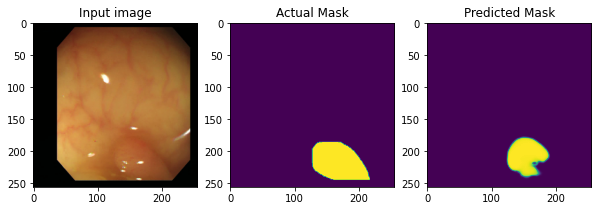

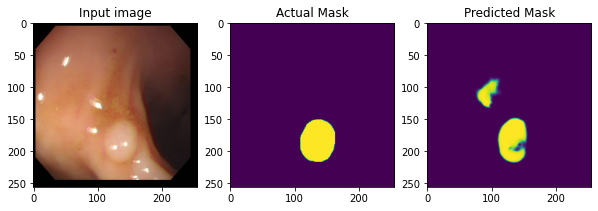

In [122]:
# v.4
print_images()

# end